In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [3]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [24]:
def get_circle(size=None):
    im = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i-size/2-1/2)**2 + (j-size/2-1/2)**2 < (0.3*size)**2:
                im[i,j] = 1
    return im

def get_circle_seq_at(size, n_per_side, at_i):
    bs = int(np.floor(size/n_per_side))
    at_i = at_i % n_per_side**2
    i = at_i // n_per_side
    j = at_i %  n_per_side
    im = np.zeros((size,size))
    im[i*bs:(i+1)*bs, j*bs:(j+1)*bs] = get_circle(size=bs)
    return np.einsum('i,jk->ijk', np.ones((size,)), im)

In [ ]:
# don't run this
from PIL import Image # just for fun, you don't need this

def get_random_icon(size=None, flat=False, prefix='../../resources/icons'):
    fn = np.random.choice([f for f in os.listdir(prefix) if f.endswith('.png')])
    im = Image.open(f'{prefix}/{fn}')
    if size is not None:
        im = im.resize((size, size))
    else:
        size = im.height
    im = np.array(im, dtype=np.float32)
    im = np.dot(im, [0.299, 0.587, 0.114, 0.]) * im[:,:,-1]
    if not flat:
        im = np.einsum('i,jk->ijk', np.ones((size,)), im)
    return np.clip(im / np.max(im), 0, 1)

def get_random_icon_seq_at(size, n_per_side, at_i):
    bs = int(np.floor(size/n_per_side))
    at_i = at_i % n_per_side**2
    i = at_i // n_per_side
    j = at_i %  n_per_side
    im = np.zeros((size,size))
    im[i*bs:(i+1)*bs, j*bs:(j+1)*bs] = get_random_icon(size=bs, flat=True)
    return np.einsum('i,jk->ijk', np.ones((size,)), im)

## Test run

In [19]:
cache_tools.clear_cache()

2023-02-17 11:08:31,461 | INFO | Removing InputHeating_58026bbb74ac793edae008198ca489eb_r54321.h5
2023-02-17 11:08:31,469 | INFO | Removing PerturbedField_90a898f9a6259155613ab20b1ad1ea16_r54321.h5
2023-02-17 11:08:31,476 | INFO | Removing InputJAlpha_4275ae24fde4e89c40548ab9346b561c_r54321.h5
2023-02-17 11:08:31,482 | INFO | Removing InputHeating_ca3f89d59a7e4dc1c5c4e6eccf91cc7b_r54321.h5
2023-02-17 11:08:31,487 | INFO | Removing InputIonization_9000651720eb0ec6db30459e86fc9102_r54321.h5
2023-02-17 11:08:31,492 | INFO | Removing InputIonization_5cbdb66c1525ba1dca8684011330154c_r54321.h5
2023-02-17 11:08:31,497 | INFO | Removing InitialConditions_2eda6b944366038a89d6590f0449374d_r54321.h5
2023-02-17 11:08:31,529 | INFO | Removing TsBox_33d967e575e9968bbb5424550d05ac4a_r54321.h5
2023-02-17 11:08:31,534 | INFO | Removing InputJAlpha_39fc7df13c8d11efa74c67a4d9b8744b_r54321.h5
2023-02-17 11:08:31,535 | INFO | Removed 9 files from cache.


In [20]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321
)

perturbed_field = p21c.perturb_field(redshift=25.0, init_boxes = initial_conditions)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


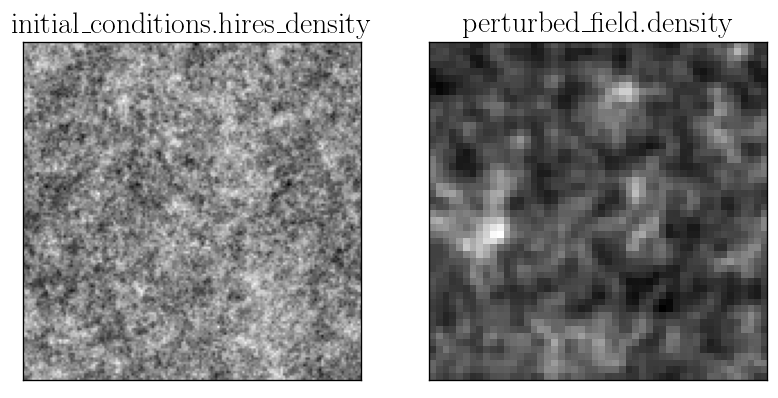

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(initial_conditions.hires_density[25], cmap='binary_r')
axs[1].imshow(perturbed_field.density[25], cmap='binary_r')

axs[0].set(title='initial_conditions.hires_density', xticks=[], yticks=[])
axs[1].set(title='perturbed_field.density', xticks=[], yticks=[]);

In [22]:
# redshift array
rs_arr = 35*1.05**(-np.array(range(10)))
print(rs_arr)

[35.         33.33333333 31.74603175 30.23431595 28.79458662 27.42341583
 26.11753888 24.87384655 23.68937767 22.56131207]


In [ ]:
Tk_box_arr = []

for i_rs, rs in enumerate(rs_arr[:3]):
    
    print(i_rs, rs)
    rs_next = rs_arr[i_rs+1]
    
    input_heating = p21c.input_heating(redshift=rs, init_boxes=initial_conditions, write=True)
    input_ionization = p21c.input_ionization(redshift=rs, init_boxes=initial_conditions, write=True)
    input_jalpha = p21c.input_jalpha(redshift=rs, init_boxes=initial_conditions, write=True)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_rs) # random picture
    #input_ionization.input_ionization += get_random_icon(size=50) * 1e-5
    
    spin_temp = p21c.spin_temperature(
        redshift=rs_next,
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_rs==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        zprime_step_factor=1.05, write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


0 35.0
Just Before Box Evaluation


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


1 33.33333333333333
Just Before Box Evaluation


IndexError: list index out of range

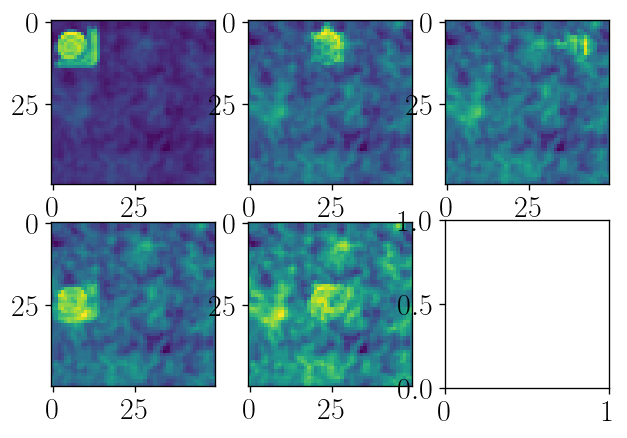

In [10]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        axs[i,j].imshow(Tk_box_arr[i*3+j][25])

[Text(0.5, 1.0, 'input_ionization'), [], []]

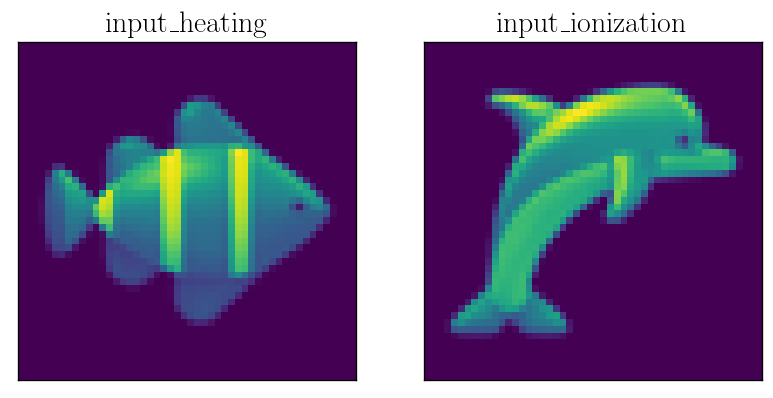

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title='input_heating', xticks=[], yticks=[])
axs[1].set(title='input_ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


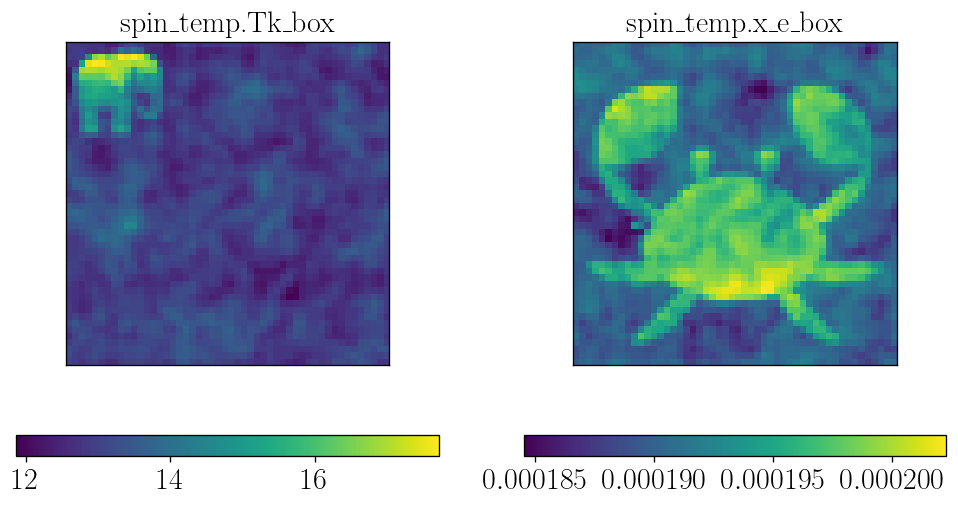

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')